In [2]:
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt
import os
import copy

from joint import Joint
from user import User
from user_setting import impact_number, Kimura, Sugawara
from MEMD_all import memd
import bvh
import ht

In [3]:
# check 1
# setting joint
j = Joint()
set_joint = j.hip

# check 2 Setting Impact Frame

select_data = Sugawara().slice_data
ballistic = select_data['select_data']
impact_list = select_data['impact_list']
follor_throught = select_data['follor_throught']

# min_frame -> 一番最小のフレームデータを選択

min_frame = np.array(impact_list)
min_frame = np.min(min_frame)
print(min_frame)

# check 3
# setting follor_throught -> インパクトからフォロースルーまでのフレームデータを計算
follor_throught = 233 - min_frame

print(follor_throught)


#check 4
output = 'output_image'
user_name = 'sugawara'
user = User(user_name=user_name, set_joint=set_joint, ballistic=ballistic, impact_list=impact_list, last_frame=follor_throught)


180
53
output_image/sugawara/slice_data/hip


In [4]:
from hht import get_data, MultEmpModeDeco
data_path = select_data['data_path']
result_memd_list = []

for i, data in enumerate(data_path):
    #
    data, dt, text = get_data(data, set_joint)
    result_memd = MultEmpModeDeco(data=data, dt=dt, set_joint=set_joint)
    result_memd_list.append(result_memd)
    

In [5]:
from hht import HilbertTrans
Nod = 6
resutl_hilbert_list = []

for i, result_memd in enumerate(result_memd_list):
    result_ht = HilbertTrans(result_memd=result_memd, select_data=select_data)
    result_ht.calc_means_norm()
    result_ht.set_freq_data(Nod=Nod, impact_number=impact_number[i])
    result_ht.set_amp_data(Nod=Nod, impact_number=impact_number[i])
    resutl_hilbert_list.append(result_ht)

35
(6, 233)
(6, 233)
0
(6, 233)
(6, 233)
30
(6, 233)
(6, 233)


In [6]:
from hht import freq_amp_mean_norm
freq_all_data, amp_norm_data = freq_amp_mean_norm(result_hilbert_list=resutl_hilbert_list)

[[ 46.61151639  43.99458709  37.44366264 ... -37.437517     4.05011105
    9.76115385]
 [ 16.17703642  14.83059154  21.98139826 ...  21.0540762   29.33507553
   21.04452729]
 [ 12.6478272    8.37703633  10.57655041 ...  10.36653811  12.59394983
   11.447283  ]
 [  6.85163804   3.8847866    5.33487542 ...   5.76452934   4.72456827
    5.78851542]
 [  5.13312069   2.05615407   3.49854983 ...   3.79446017   4.0105323
    3.8019296 ]
 [  5.27698645   1.2377613    2.96418501 ...   2.08397327   2.20234851
    2.08213768]]


In [ ]:
# setting frame data
first_freq_data = first_freq_data[:6, first_impact - min_frame : first_impact + follor_throught]
first_amp_data = first_amp_data[:6, first_impact - min_frame : first_impact + follor_throught]

second_freq_data = second_freq_data[:6, second_impact - min_frame : second_impact + follor_throught]
second_amp_data = second_amp_data[:6, second_impact - min_frame : second_impact + follor_throught]

third_freq_data = third_freq_data[:6, third_impact - min_frame : third_impact + follor_throught]
third_amp_data = third_amp_data[:6, third_impact - min_frame : third_impact + follor_throught]

# all data means or norm
all_freq_data = (first_freq_data + second_freq_data + third_freq_data) / 3
all_amp_data = (first_amp_data + second_amp_data + third_amp_data) / 3
all_amp_data = (all_amp_data - np.min(all_amp_data)) / (np.max(all_amp_data) - np.min(all_amp_data))

# Number of decomposition
Nod = all_freq_data.shape[0]
#frame 
frame = all_freq_data.shape[1]

# setting spectrum time
spectrum_time = np.zeros((Nod, frame))
for n in range(Nod):
    spectrum_time[n, :] = np.linspace(0, dt*frame, frame)
print(spectrum_time.shape)

<Figure size 432x288 with 0 Axes>

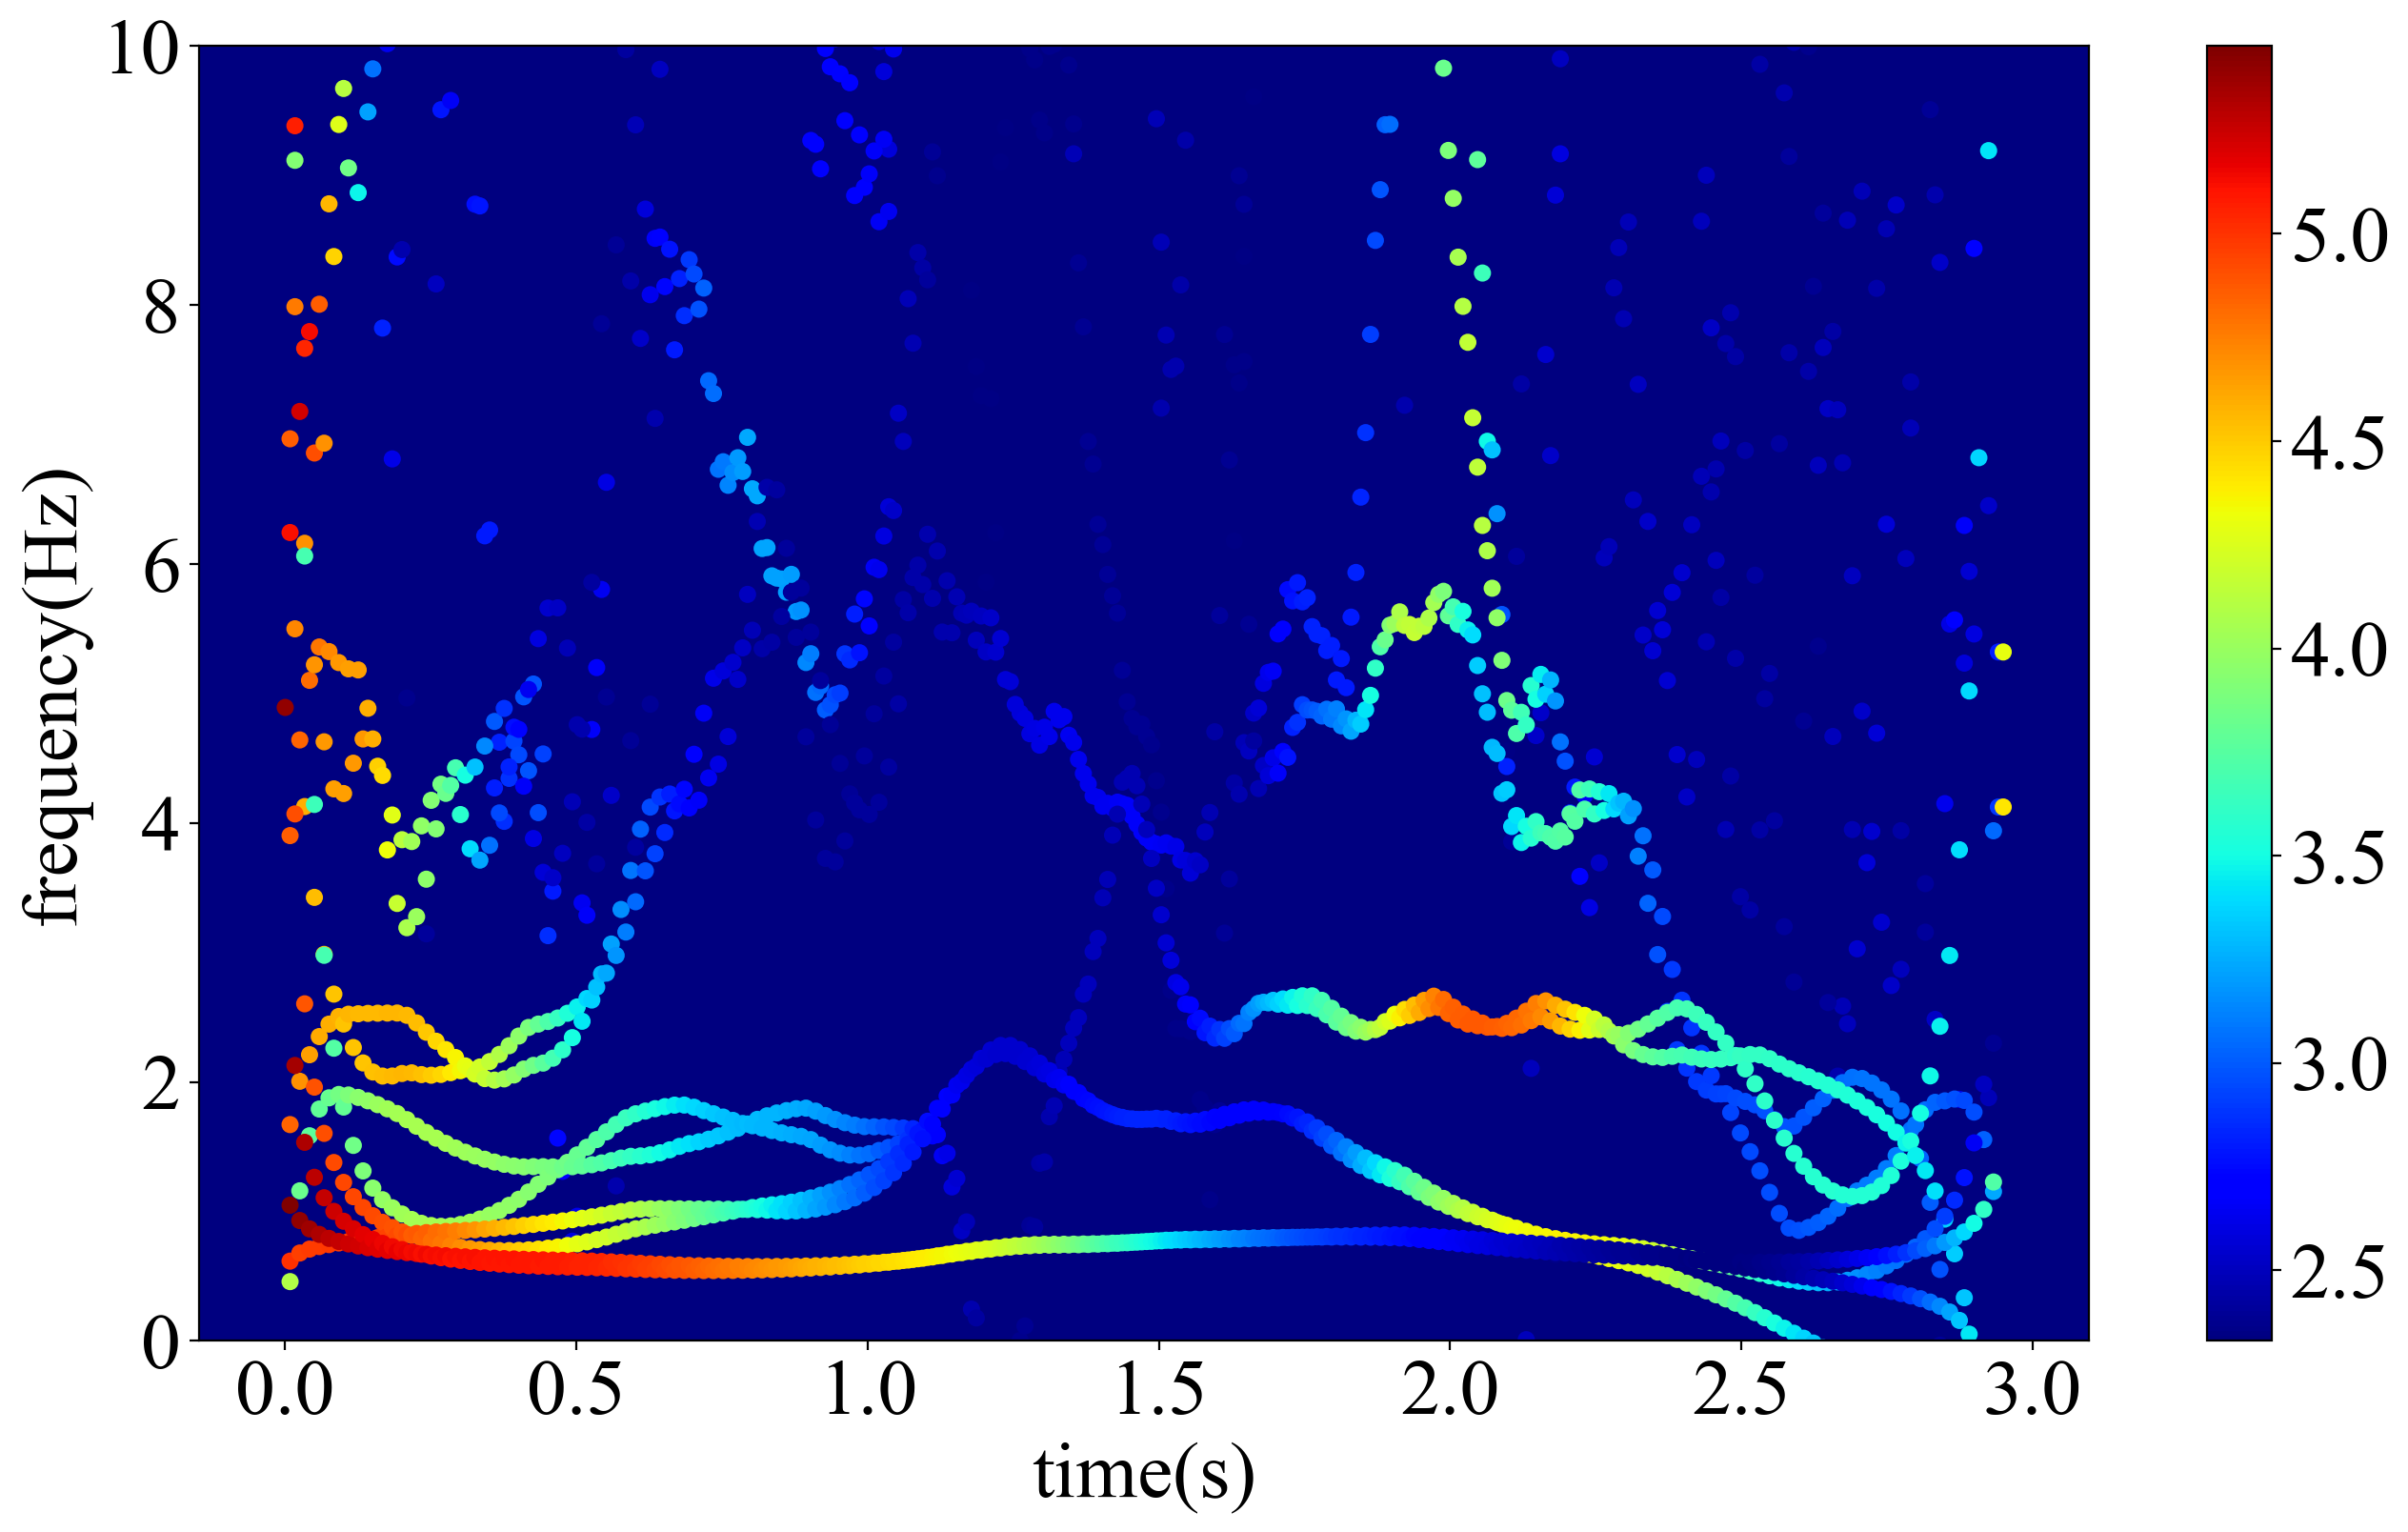

In [23]:
# first straight data
# or
# first slice data
# data_path = '../data/1111/straight_data/straight_1_Take_001.bvh'
# data_path = '../data/1111/slice_data/slice_1_Take_001.bvh'
data_path = '../data/sugawara/slice_data/singlePlane_slice01_Take_001.bvh'

data, fs, text = bvh.bvhreader(data_path)
data = bvh.errc(data, set_joint, set_joint+3)
dt = float(fs)
imf = memd(data)

result_x = imf[:, set_joint, :]
result_z = imf[:, set_joint+1, :]
result_y = imf[:, set_joint+2, :]

# Hilbert Huang Transportation
freq_x, amp_x = ht.FAhilbert(result_x, dt)
freq_z, amp_z = ht.FAhilbert(result_z, dt)
freq_y, amp_y = ht.FAhilbert(result_y, dt)

# freq_x,y,z amp_x,y,z -> 転置
freq_x = freq_x.T
freq_z = freq_z.T
freq_y = freq_y.T

amp_x = amp_x.T
amp_z = amp_z.T
amp_y = amp_y.T

# freq and amp setting
freq_all = np.array([freq_x, freq_z, freq_y])
amp_all = np.array([amp_x, amp_z, amp_y])

# freq means
freq_mean = np.mean(freq_all, axis=0)

# amp normalize
amp_norm = LA.norm(amp_all, axis=0)
# amp_mean = (amp_norm - np.min(amp_norm)) / (np.max(amp_norm) - np.min(amp_norm))

# Number of decomposition
Nod = freq_mean.shape[0]

# frame 
frame = freq_mean.shape[1]

# setting spectrum time
spectrum_time = np.zeros((Nod, frame))
for n in range(Nod):
    spectrum_time[n, :] = np.linspace(0, dt*frame, frame)
    
# spectrogram plot
plt.clf()
plt.figure(dpi = 200, figsize=(16, 9))
plt.rcParams['font.family'] = 'Times new Roman'
plt.rcParams['font.size'] = 30
for n in range(Nod):
    plt.scatter(spectrum_time[n, :], freq_mean[n, :], s = 30, c=amp_norm[n, :frame], cmap='jet')
ax = plt.gca()
ax.set_facecolor([0.0, 0.0, 0.5])
plt.ylim(0, 10)
plt.xlabel('time(s)')
plt.ylabel('frequency(Hz)')
plt.colorbar()
plt.show()

In [24]:
first_freq_data = freq_mean.copy()
first_amp_data = amp_norm.copy()

<Figure size 432x288 with 0 Axes>

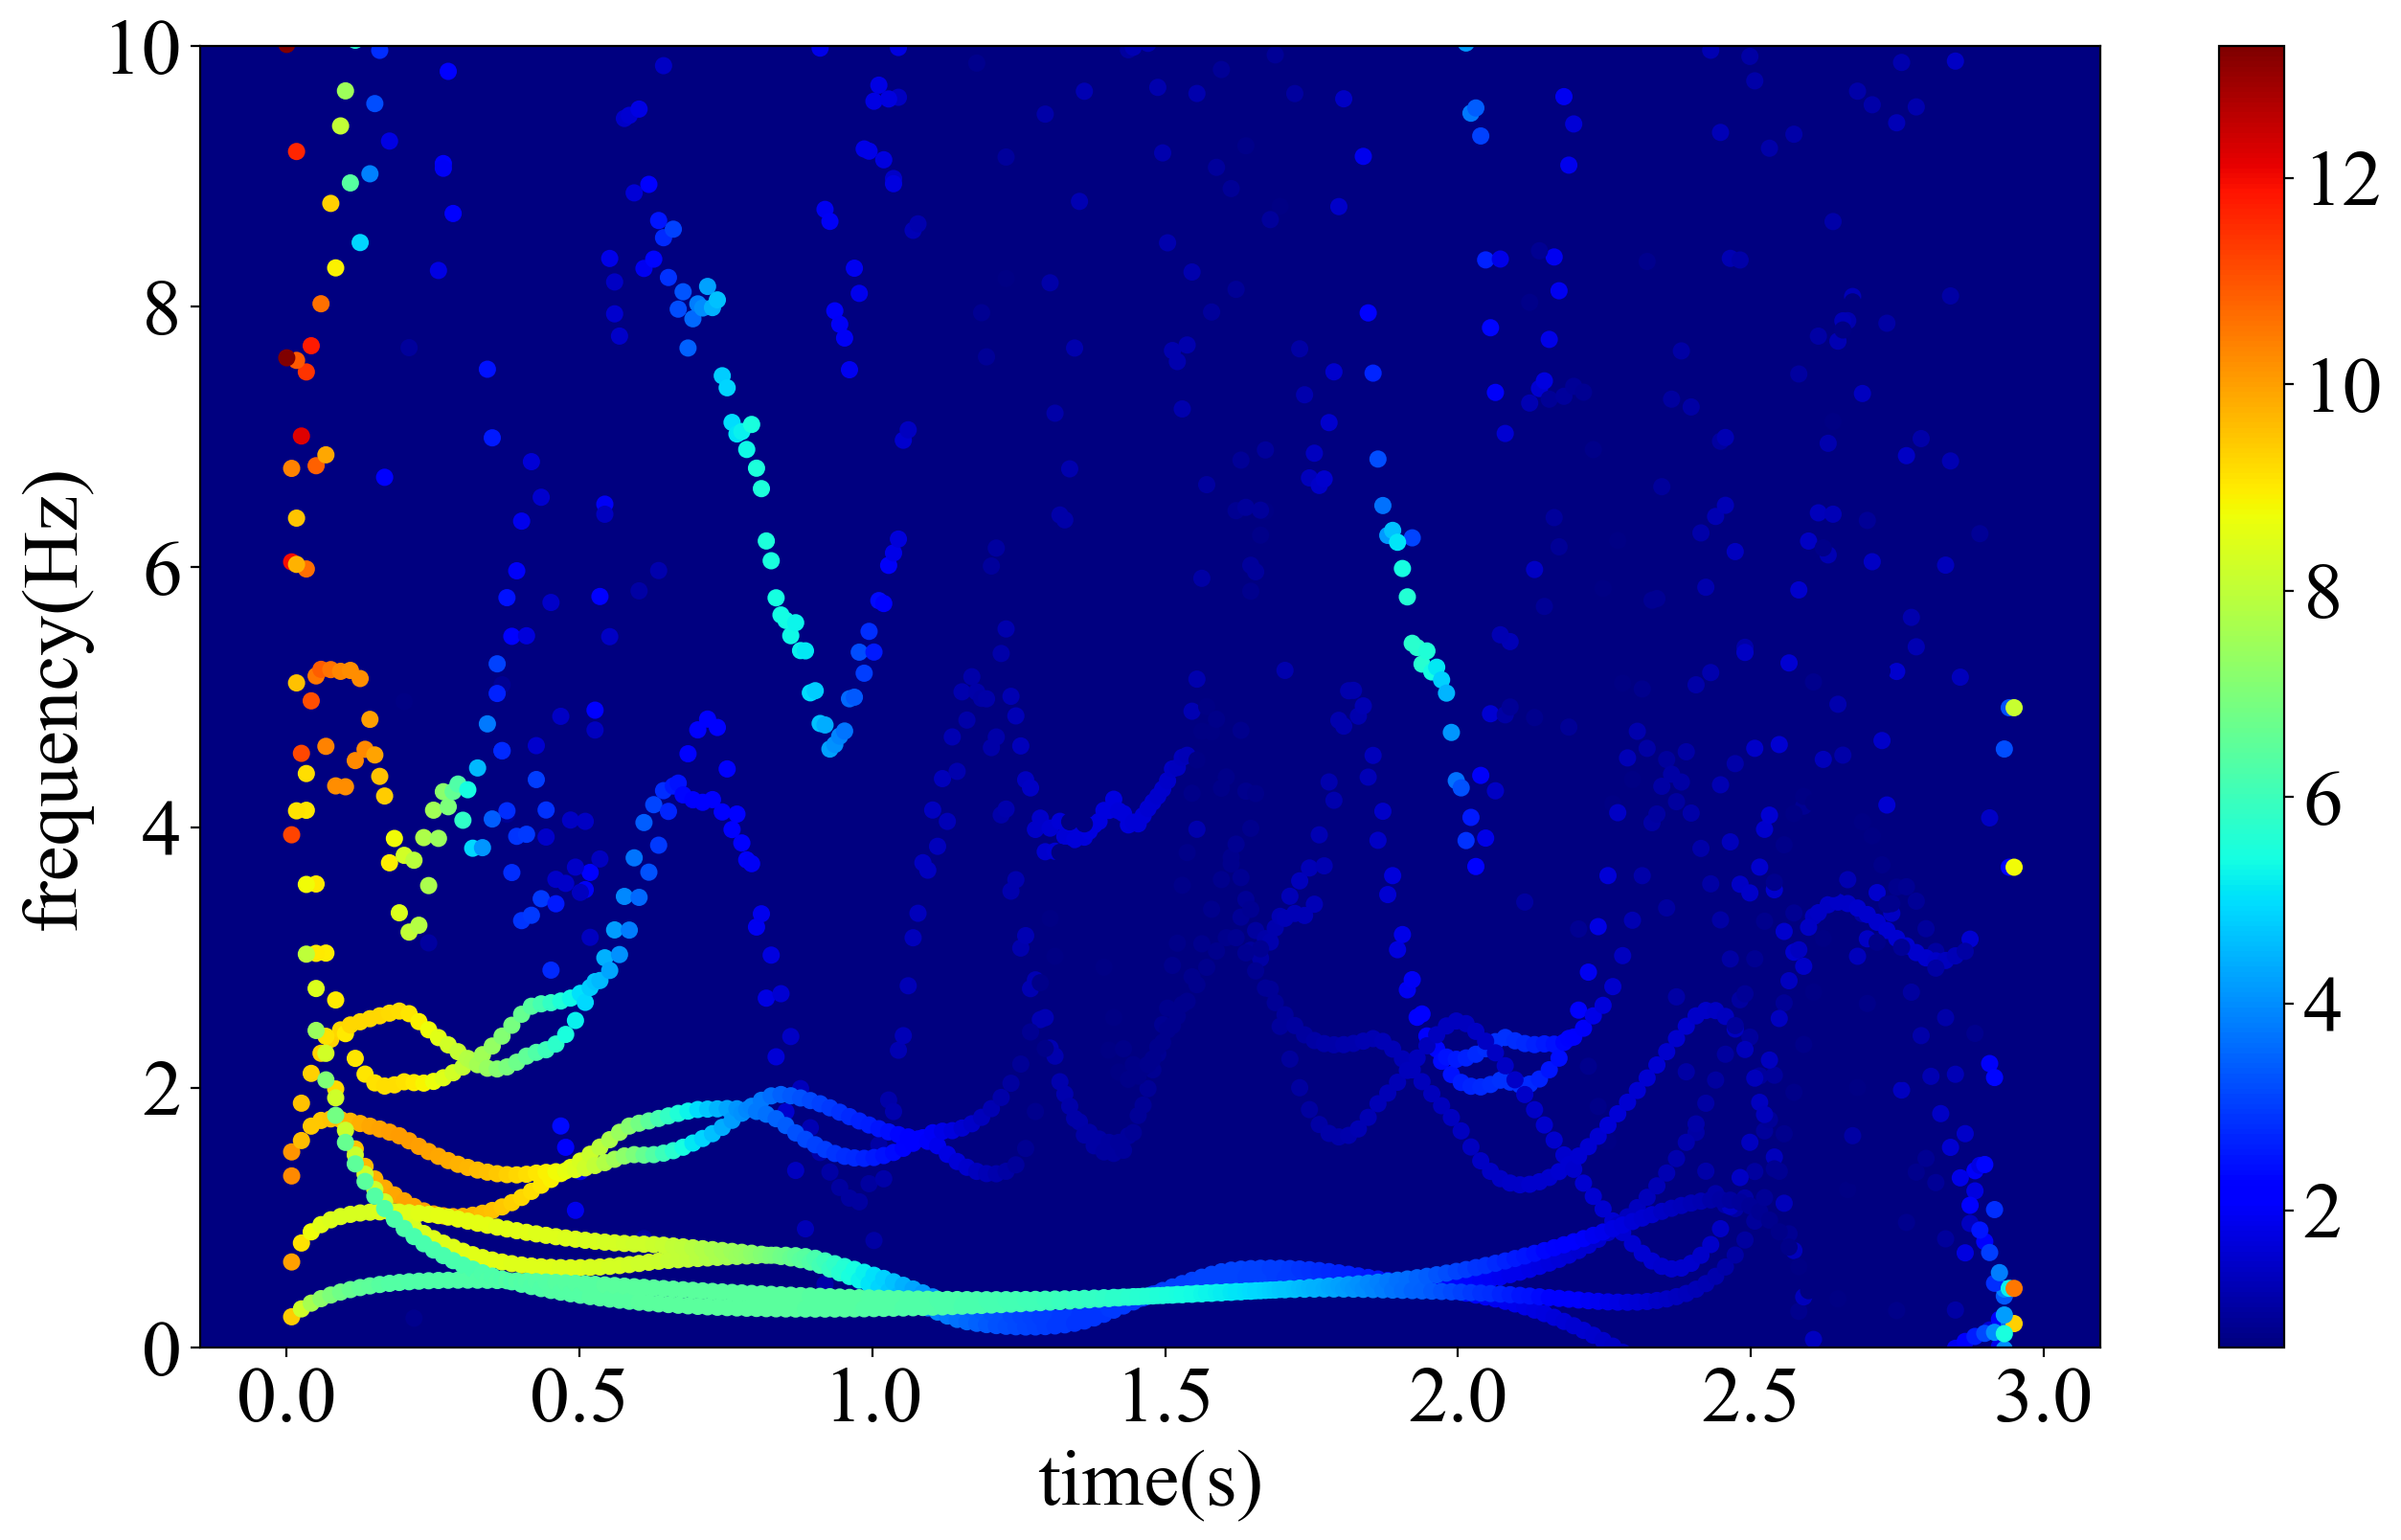

In [25]:
# secont straight data
# data_path = '../data/1111/straight_data/straight_2_Take_001.bvh'
# data_path = '../data/1111/slice_data/slice_2_Take_001.bvh'
data_path = '../data/sugawara/slice_data/singlePlane_slice02_Take_001.bvh'

data, fs, text = bvh.bvhreader(data_path)
data = bvh.errc(data, set_joint, set_joint+3)
dt = float(fs)
imf = memd(data)

result_x = imf[:, set_joint, :]
result_z = imf[:, set_joint+1, :]
result_y = imf[:, set_joint+2, :]

# Hilbert Huang Transportation
freq_x, amp_x = ht.FAhilbert(result_x, dt)
freq_z, amp_z = ht.FAhilbert(result_z, dt)
freq_y, amp_y = ht.FAhilbert(result_y, dt)

# freq_x,y,z amp_x,y,z -> 転置
freq_x = freq_x.T
freq_z = freq_z.T
freq_y = freq_y.T

amp_x = amp_x.T
amp_z = amp_z.T
amp_y = amp_y.T

# freq and amp setting
freq_all = np.array([freq_x, freq_z, freq_y])
amp_all = np.array([amp_x, amp_z, amp_y])

# freq means
freq_mean = np.mean(freq_all, axis=0)

# amp normalize
amp_norm = LA.norm(amp_all, axis=0)
# amp_mean = (amp_norm - np.min(amp_norm)) / (np.max(amp_norm) - np.min(amp_norm))

# Number of decomposition
Nod = freq_mean.shape[0]

# frame 
frame = freq_mean.shape[1]

# setting spectrum time
spectrum_time = np.zeros((Nod, frame))
for n in range(Nod):
    spectrum_time[n, :] = np.linspace(0, dt*frame, frame)
    
# spectrogram plot
plt.clf()
plt.figure(dpi = 200, figsize=(16, 9))
plt.rcParams['font.family'] = 'Times new Roman'
plt.rcParams['font.size'] = 30
for n in range(Nod):
    plt.scatter(spectrum_time[n, :], freq_mean[n, :], s = 30, c=amp_norm[n, :frame], cmap='jet')
ax = plt.gca()
ax.set_facecolor([0.0, 0.0, 0.5])
plt.ylim(0, 10)
plt.xlabel('time(s)')
plt.ylabel('frequency(Hz)')
plt.colorbar()
plt.show()

In [26]:
second_freq_data = freq_mean.copy()
second_amp_data = amp_norm.copy()

<Figure size 432x288 with 0 Axes>

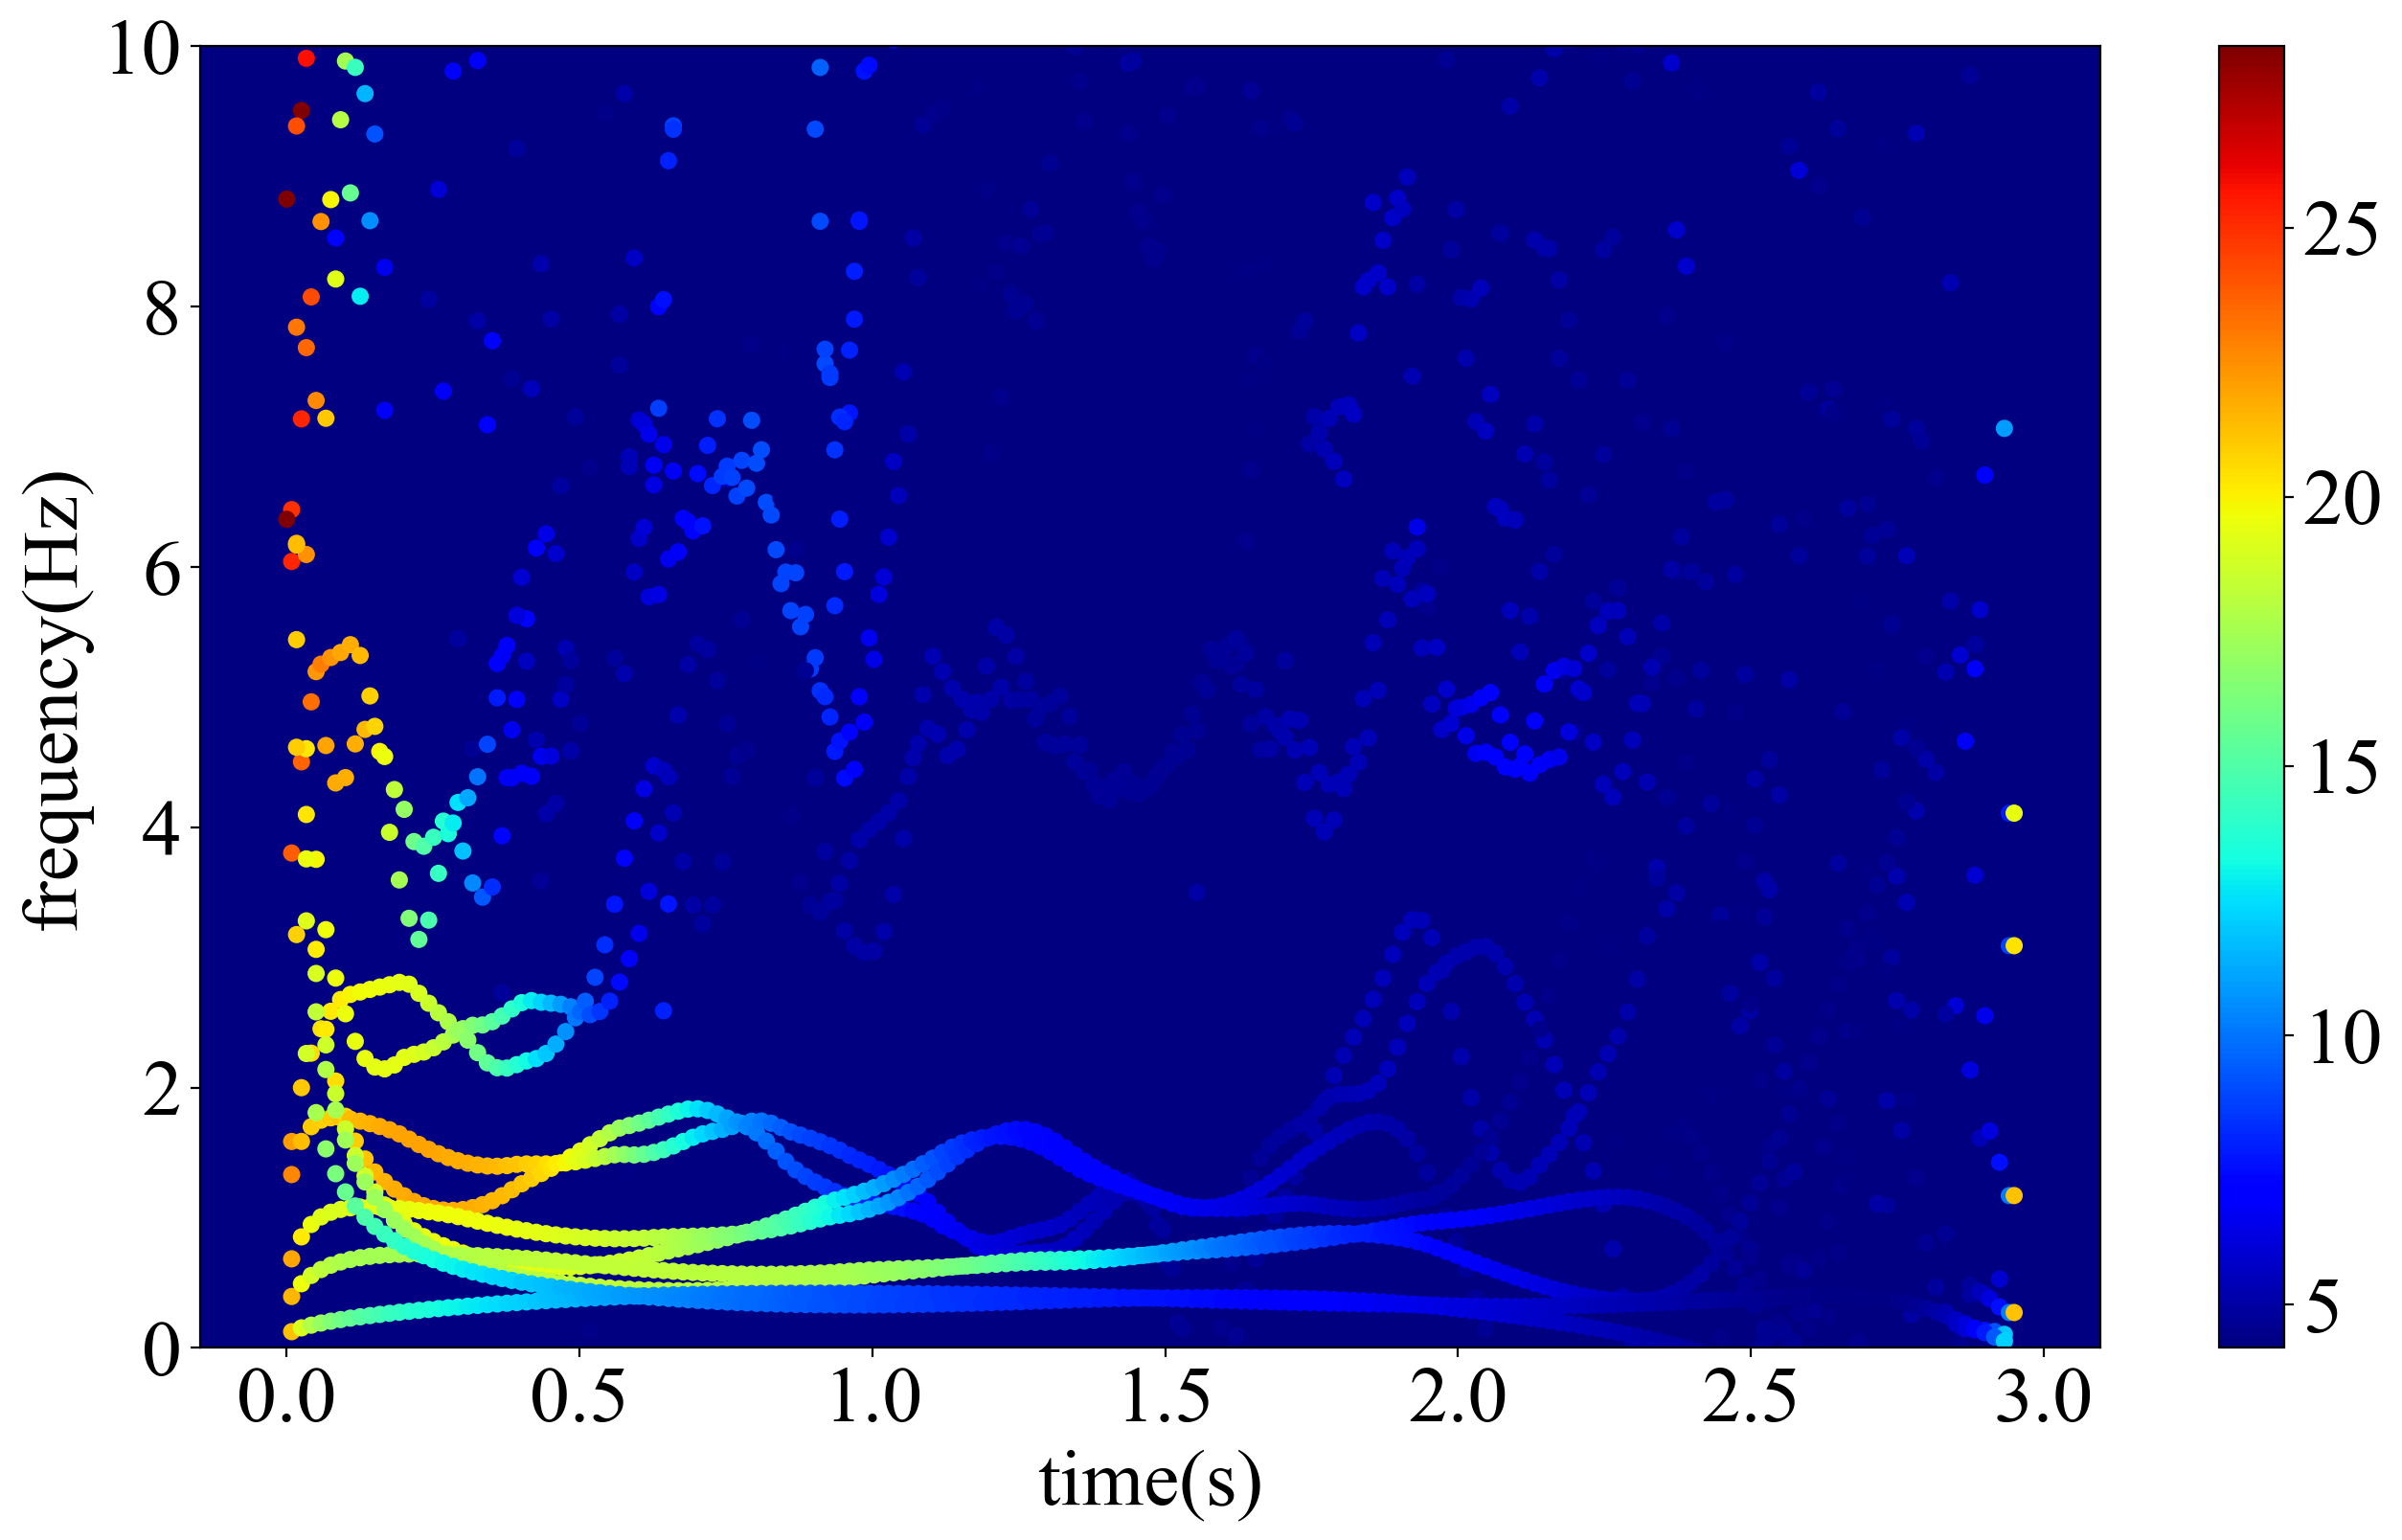

In [27]:
# third straight data
# data_path = '../data/1111/straight_data/straight_3_Take_001.bvh'
# data_path = '../data/1111/slice_data/slice_3_Take_001.bvh'
data_path = '../data/sugawara/slice_data/singlePlane_slice03_Take_001.bvh'

data, fs, text = bvh.bvhreader(data_path)
data = bvh.errc(data, set_joint, set_joint+3)
dt = float(fs)
imf = memd(data)

result_x = imf[:, set_joint, :]
result_z = imf[:, set_joint+1, :]
result_y = imf[:, set_joint+2, :]

# Hilbert Huang Transportation
freq_x, amp_x = ht.FAhilbert(result_x, dt)
freq_z, amp_z = ht.FAhilbert(result_z, dt)
freq_y, amp_y = ht.FAhilbert(result_y, dt)

# freq_x,y,z amp_x,y,z -> 転置
freq_x = freq_x.T
freq_z = freq_z.T
freq_y = freq_y.T

amp_x = amp_x.T
amp_z = amp_z.T
amp_y = amp_y.T

# freq and amp setting
freq_all = np.array([freq_x, freq_z, freq_y])
amp_all = np.array([amp_x, amp_z, amp_y])

# freq means
freq_mean = np.mean(freq_all, axis=0)

# amp normalize
amp_norm = LA.norm(amp_all, axis=0)
# amp_mean = (amp_norm - np.min(amp_norm)) / (np.max(amp_norm) - np.min(amp_norm))

# Number of decomposition
Nod = freq_mean.shape[0]

# frame 
frame = freq_mean.shape[1]

# setting spectrum time
spectrum_time = np.zeros((Nod, frame))
for n in range(Nod):
    spectrum_time[n, :] = np.linspace(0, dt*frame, frame)
    
# spectrogram plot
plt.clf()
plt.figure(dpi = 200, figsize=(16, 9))
plt.rcParams['font.family'] = 'Times new Roman'
plt.rcParams['font.size'] = 30
for n in range(Nod):
    plt.scatter(spectrum_time[n, :], freq_mean[n, :], s = 30, c=amp_norm[n, :frame], cmap='jet')
ax = plt.gca()
ax.set_facecolor([0.0, 0.0, 0.5])
plt.ylim(0, 10)
plt.xlabel('time(s)')
plt.ylabel('frequency(Hz)')
plt.colorbar()
plt.show()

In [28]:
third_freq_data = freq_mean.copy()
third_amp_data = amp_norm.copy()

In [29]:
print(first_freq_data.shape)
print(second_freq_data.shape)
print(third_freq_data.shape)

(8, 354)
(8, 354)
(9, 354)


In [30]:
# setting frame data
first_freq_data = first_freq_data[:6, first_impact - min_frame : first_impact + follor_throught]
first_amp_data = first_amp_data[:6, first_impact - min_frame : first_impact + follor_throught]

second_freq_data = second_freq_data[:6, second_impact - min_frame : second_impact + follor_throught]
second_amp_data = second_amp_data[:6, second_impact - min_frame : second_impact + follor_throught]

third_freq_data = third_freq_data[:6, third_impact - min_frame : third_impact + follor_throught]
third_amp_data = third_amp_data[:6, third_impact - min_frame : third_impact + follor_throught]

# all data means or norm
all_freq_data = (first_freq_data + second_freq_data + third_freq_data) / 3
all_amp_data = (first_amp_data + second_amp_data + third_amp_data) / 3
all_amp_data = (all_amp_data - np.min(all_amp_data)) / (np.max(all_amp_data) - np.min(all_amp_data))

# Number of decomposition
Nod = all_freq_data.shape[0]
#frame 
frame = all_freq_data.shape[1]

# setting spectrum time
spectrum_time = np.zeros((Nod, frame))
for n in range(Nod):
    spectrum_time[n, :] = np.linspace(0, dt*frame, frame)
print(spectrum_time.shape)

(6, 233)


slice_data
hip


<Figure size 432x288 with 0 Axes>

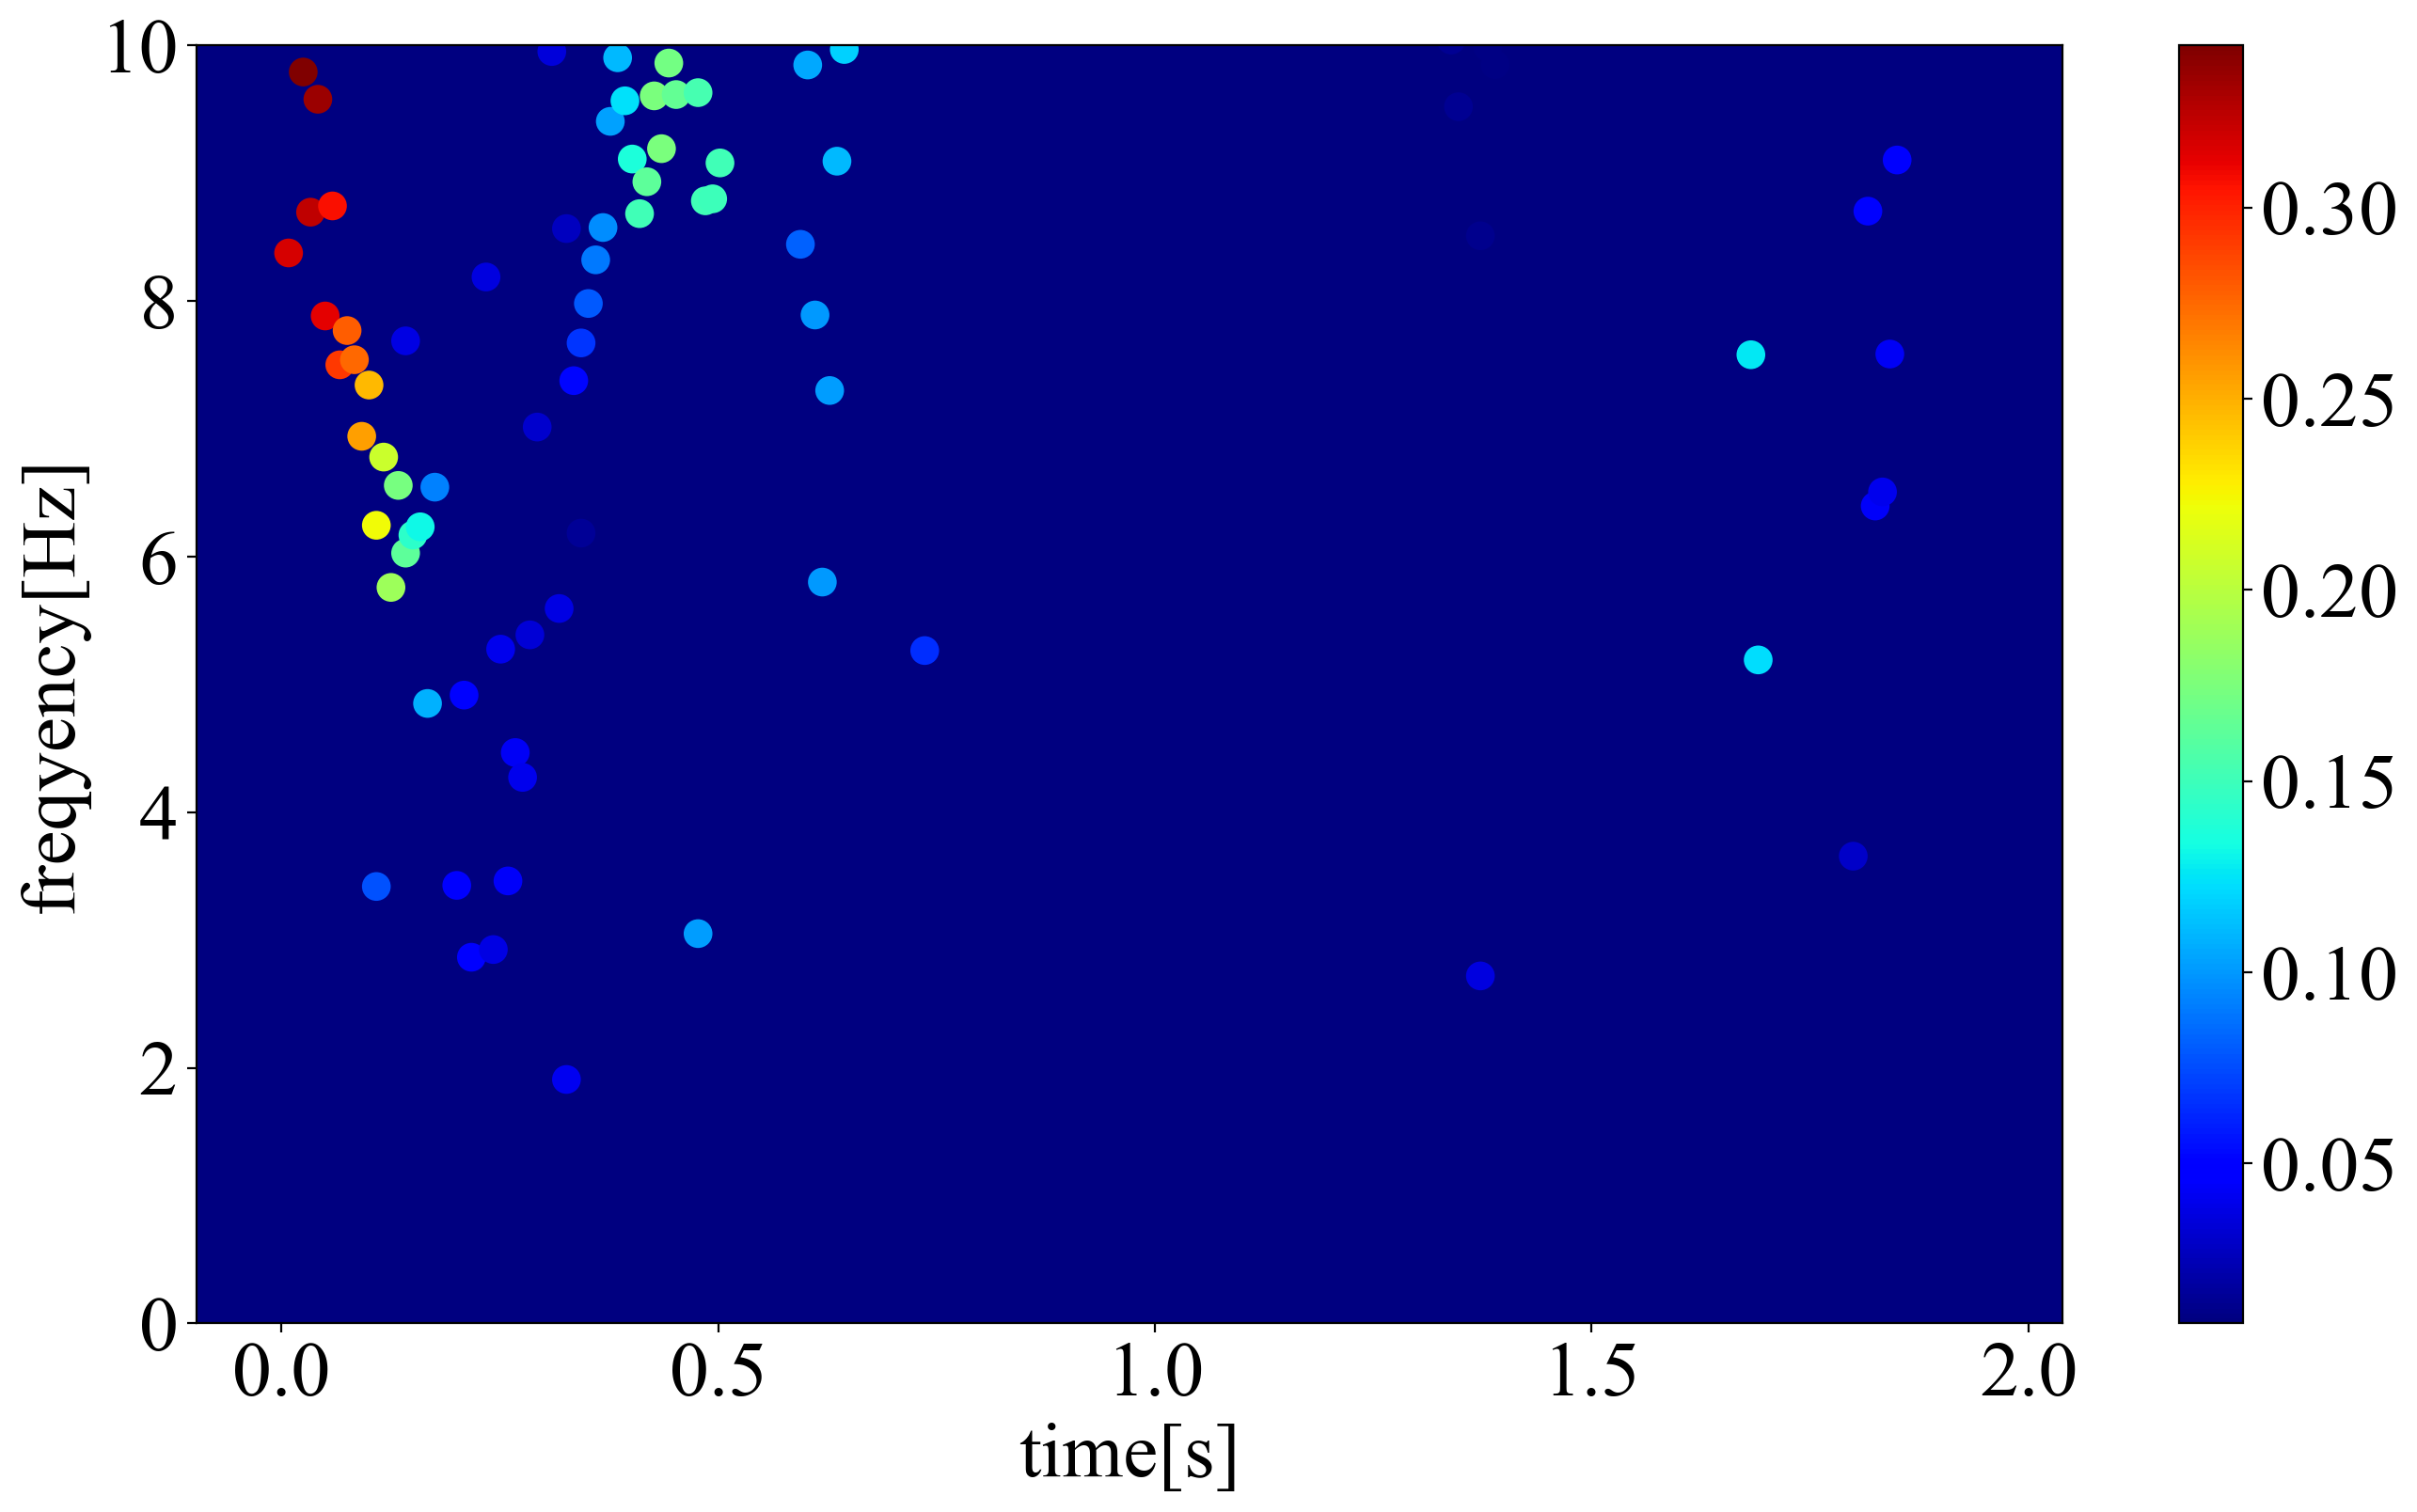

In [33]:
print(select_data)
print(joint_name)
# spectrogram plot
plt.clf()
plt.figure(dpi = 200, figsize=(16, 9))
plt.rcParams['font.family'] = 'Times new Roman'
plt.rcParams['font.size'] = 30
for n in range(1, 3):
    plt.scatter(spectrum_time[n, :], all_freq_data[n, :], s = 100, c=all_amp_data[n, :frame], cmap='jet')
ax = plt.gca()
ax.set_facecolor([0.0, 0.0, 0.5])
plt.ylim(0, 10)
plt.xlabel('time[s]')
plt.ylabel('freqyency[Hz]')
plt.colorbar()
# plt.clim(0,1)
# check 5 Rename the file after each plot
file_name = joint_name + '_' + select_data + '_' + 'IMF2_IMF3.png'
plt.savefig(os.path.join(save_path, file_name))
plt.show()

<Figure size 432x288 with 0 Axes>

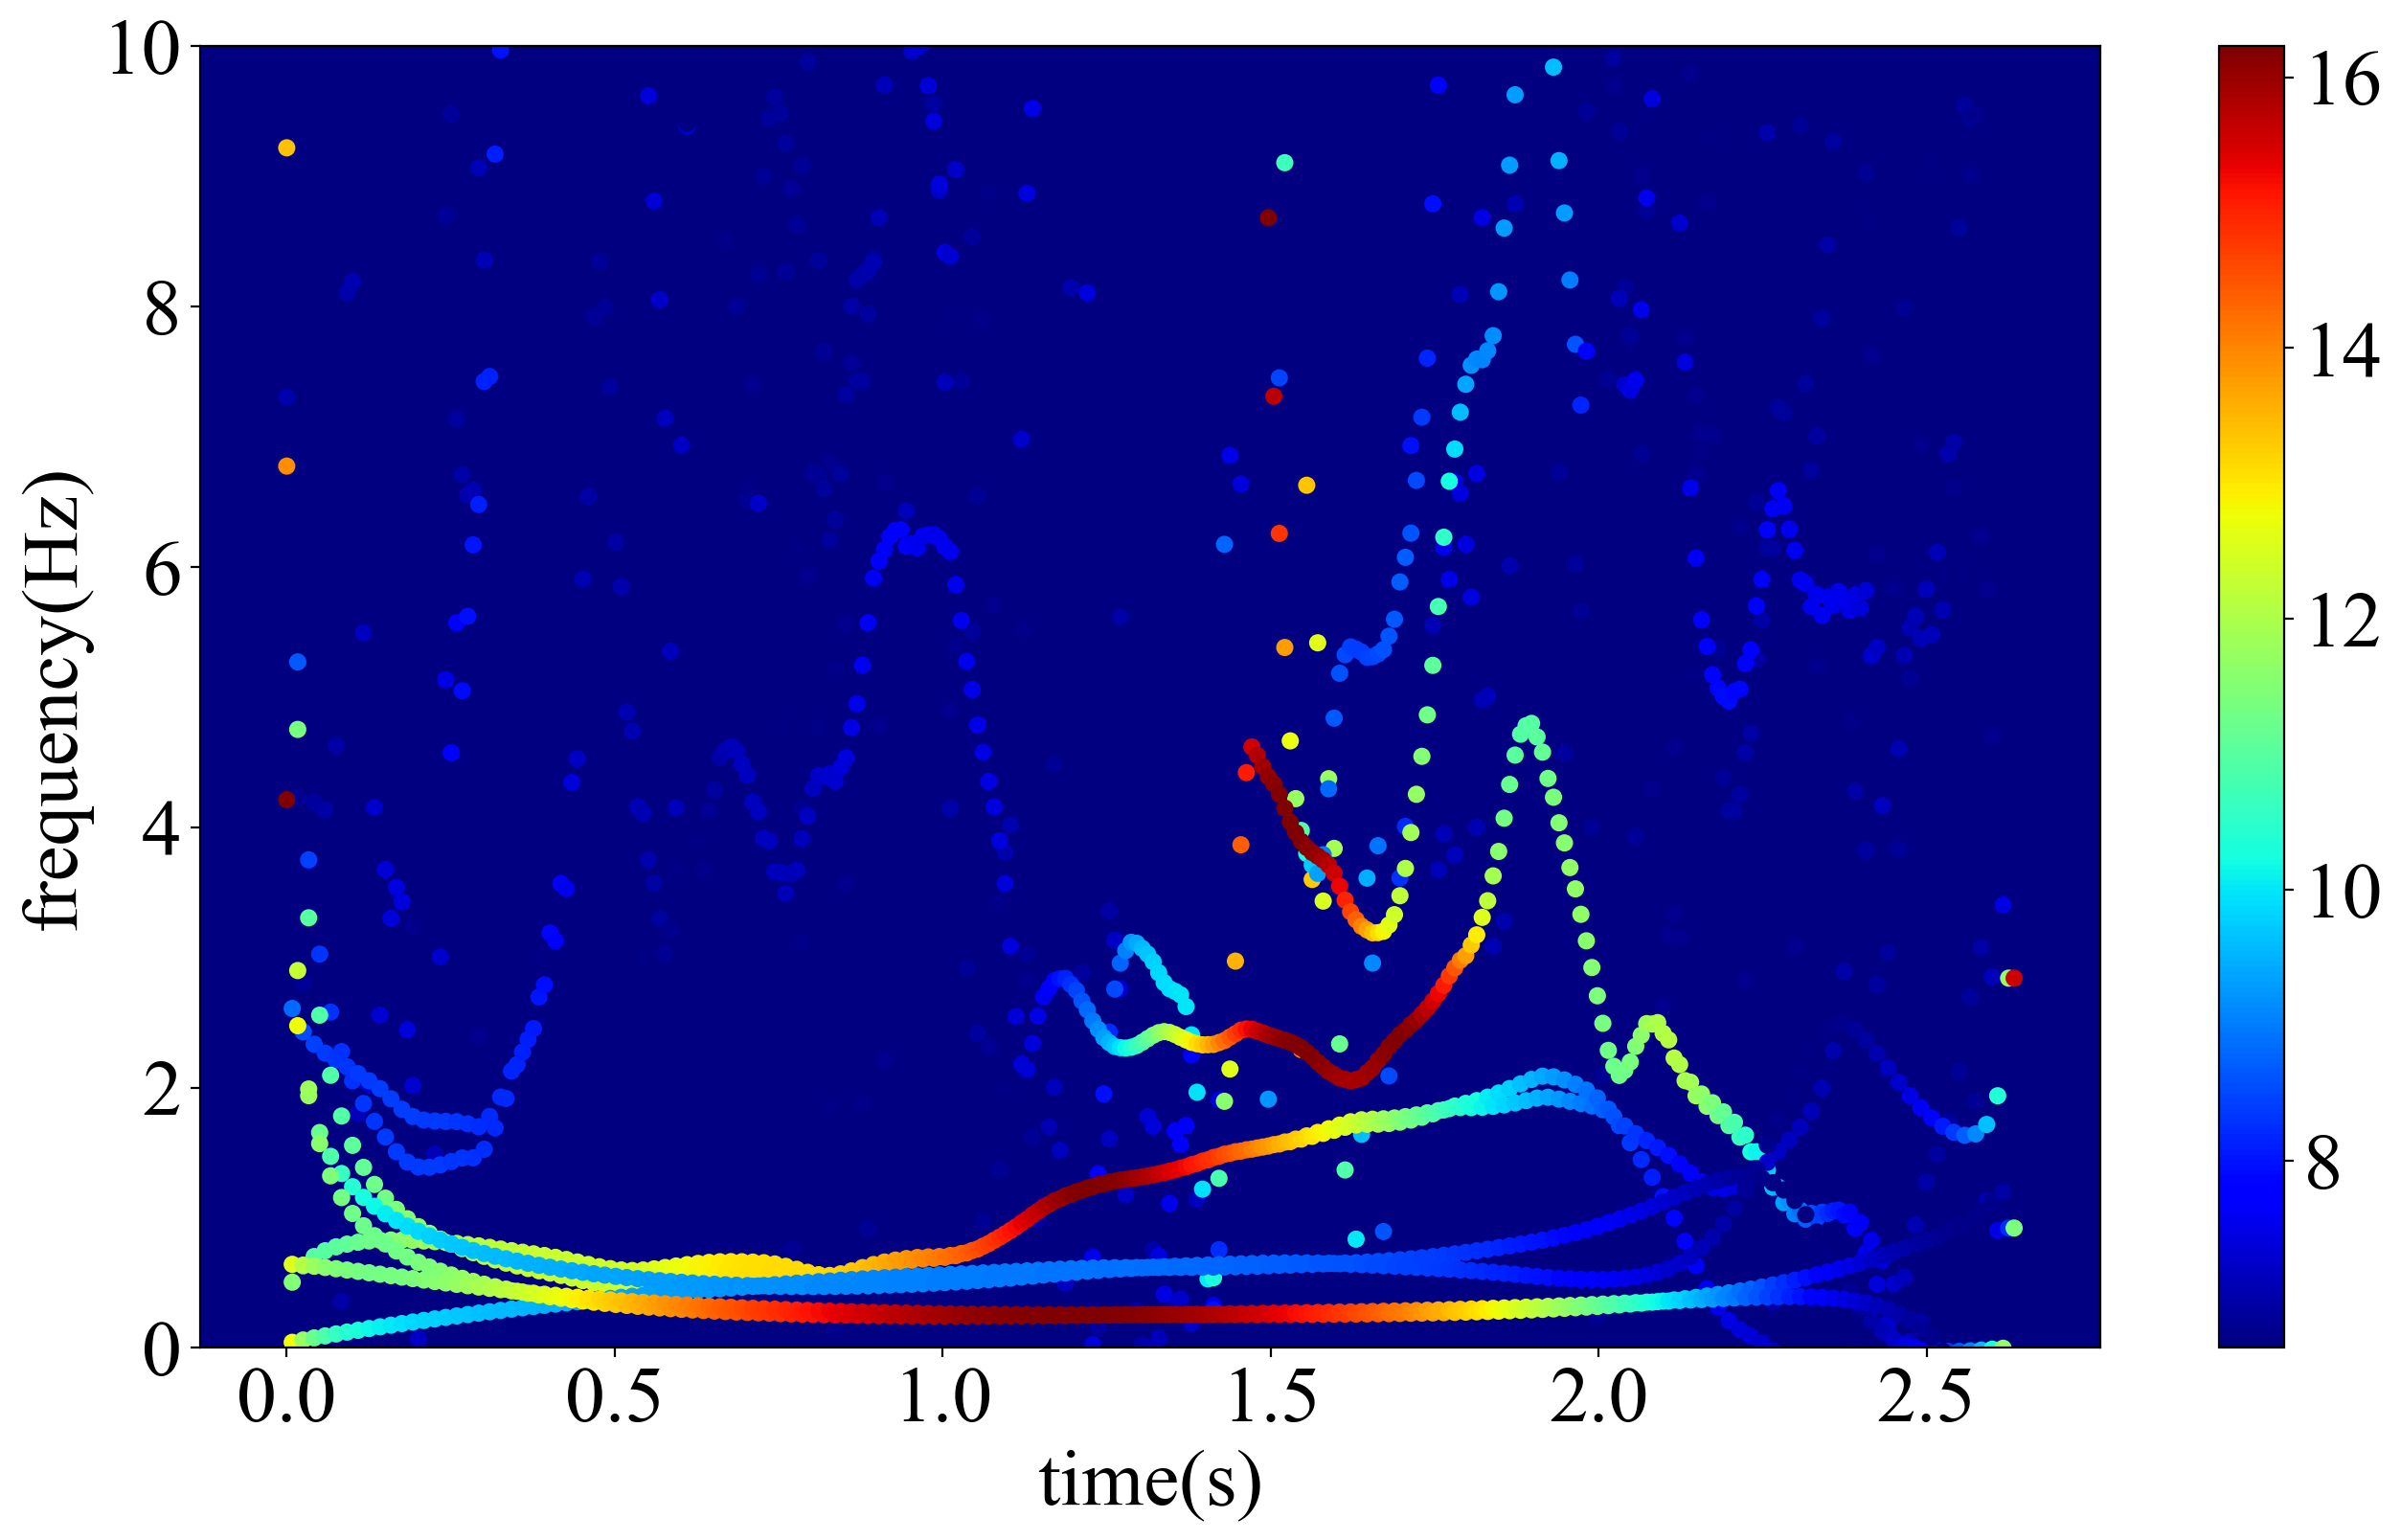

In [26]:
# fourth straight data
# data_path = '../data/1111/straight_data/straight_4_Take_001.bvh'
data_path = '../data/1111/slice_data/slice_4_Take_001.bvh'

data, fs, text = bvh.bvhreader(data_path)
data = bvh.errc(data, set_joint, set_joint+3)
dt = float(fs)
imf = memd(data)

result_x = imf[:, set_joint, :]
result_z = imf[:, set_joint+1, :]
result_y = imf[:, set_joint+2, :]

# Hilbert Huang Transportation
freq_x, amp_x = ht.FAhilbert(result_x, dt)
freq_z, amp_z = ht.FAhilbert(result_z, dt)
freq_y, amp_y = ht.FAhilbert(result_y, dt)

# freq_x,y,z amp_x,y,z -> 転置
freq_x = freq_x.T
freq_z = freq_z.T
freq_y = freq_y.T

amp_x = amp_x.T
amp_z = amp_z.T
amp_y = amp_y.T

# freq and amp setting
freq_all = np.array([freq_x, freq_z, freq_y])
amp_all = np.array([amp_x, amp_z, amp_y])

# freq means
freq_mean = np.mean(freq_all, axis=0)

# amp normalize
amp_norm = LA.norm(amp_all, axis=0)
# amp_mean = (amp_norm - np.min(amp_norm)) / (np.max(amp_norm) - np.min(amp_norm))

# Number of decomposition
Nod = freq_mean.shape[0]

# frame 
frame = freq_mean.shape[1]

# setting spectrum time
spectrum_time = np.zeros((Nod, frame))
for n in range(Nod):
    spectrum_time[n, :] = np.linspace(0, dt*frame, frame)
    
# spectrogram plot
plt.clf()
plt.figure(dpi = 200, figsize=(16, 9))
plt.rcParams['font.family'] = 'Times new Roman'
plt.rcParams['font.size'] = 30
for n in range(Nod):
    plt.scatter(spectrum_time[n, :], freq_mean[n, :], s = 30, c=amp_norm[n, :frame], cmap='jet')
ax = plt.gca()
ax.set_facecolor([0.0, 0.0, 0.5])
plt.ylim(0, 10)
plt.xlabel('time(s)')
plt.ylabel('frequency(Hz)')
plt.colorbar()
plt.show()

In [27]:
fourth_freq_data = freq_mean.copy()
fourth_amp_data = amp_norm.copy()

In [28]:
print(first_freq_data.shape)
print(second_freq_data.shape)
print(third_freq_data.shape)
print(fourth_freq_data.shape)

(7, 301)
(7, 301)
(6, 281)
(7, 316)


In [29]:
# setting frame data
first_freq_data = first_freq_data[:6, first_impact - min_frame : first_impact + follor_throught]
first_amp_data = first_amp_data[:6, first_impact - min_frame : first_impact + follor_throught]

second_freq_data = second_freq_data[:6, second_impact - min_frame : second_impact + follor_throught]
second_amp_data = second_amp_data[:6, second_impact - min_frame : second_impact + follor_throught]

third_freq_data = third_freq_data[:6, third_impact - min_frame : third_impact + follor_throught]
third_amp_data = third_amp_data[:6, third_impact - min_frame : third_impact + follor_throught]

fourth_freq_data = fourth_freq_data[:6, fourth_impact - min_frame : fourth_impact + follor_throught]
fourth_amp_data = fourth_amp_data[:6, fourth_impact - min_frame : fourth_impact + follor_throught]

# all data means or norm
all_freq_data = (first_freq_data + second_freq_data + third_freq_data + fourth_freq_data) / 4
all_amp_data = (first_amp_data + second_amp_data + third_amp_data + fourth_amp_data) / 4
all_amp_data = (all_amp_data - np.min(all_amp_data)) / (np.max(all_amp_data) - np.min(all_amp_data))

# Number of decomposition
Nod = all_freq_data.shape[0]
#frame 
frame = all_freq_data.shape[1]

# setting spectrum time
spectrum_time = np.zeros((Nod, frame))
for n in range(Nod):
    spectrum_time[n, :] = np.linspace(0, dt*frame, frame)
print(spectrum_time.shape)

(6, 246)


slice_data
left_leg


<Figure size 432x288 with 0 Axes>

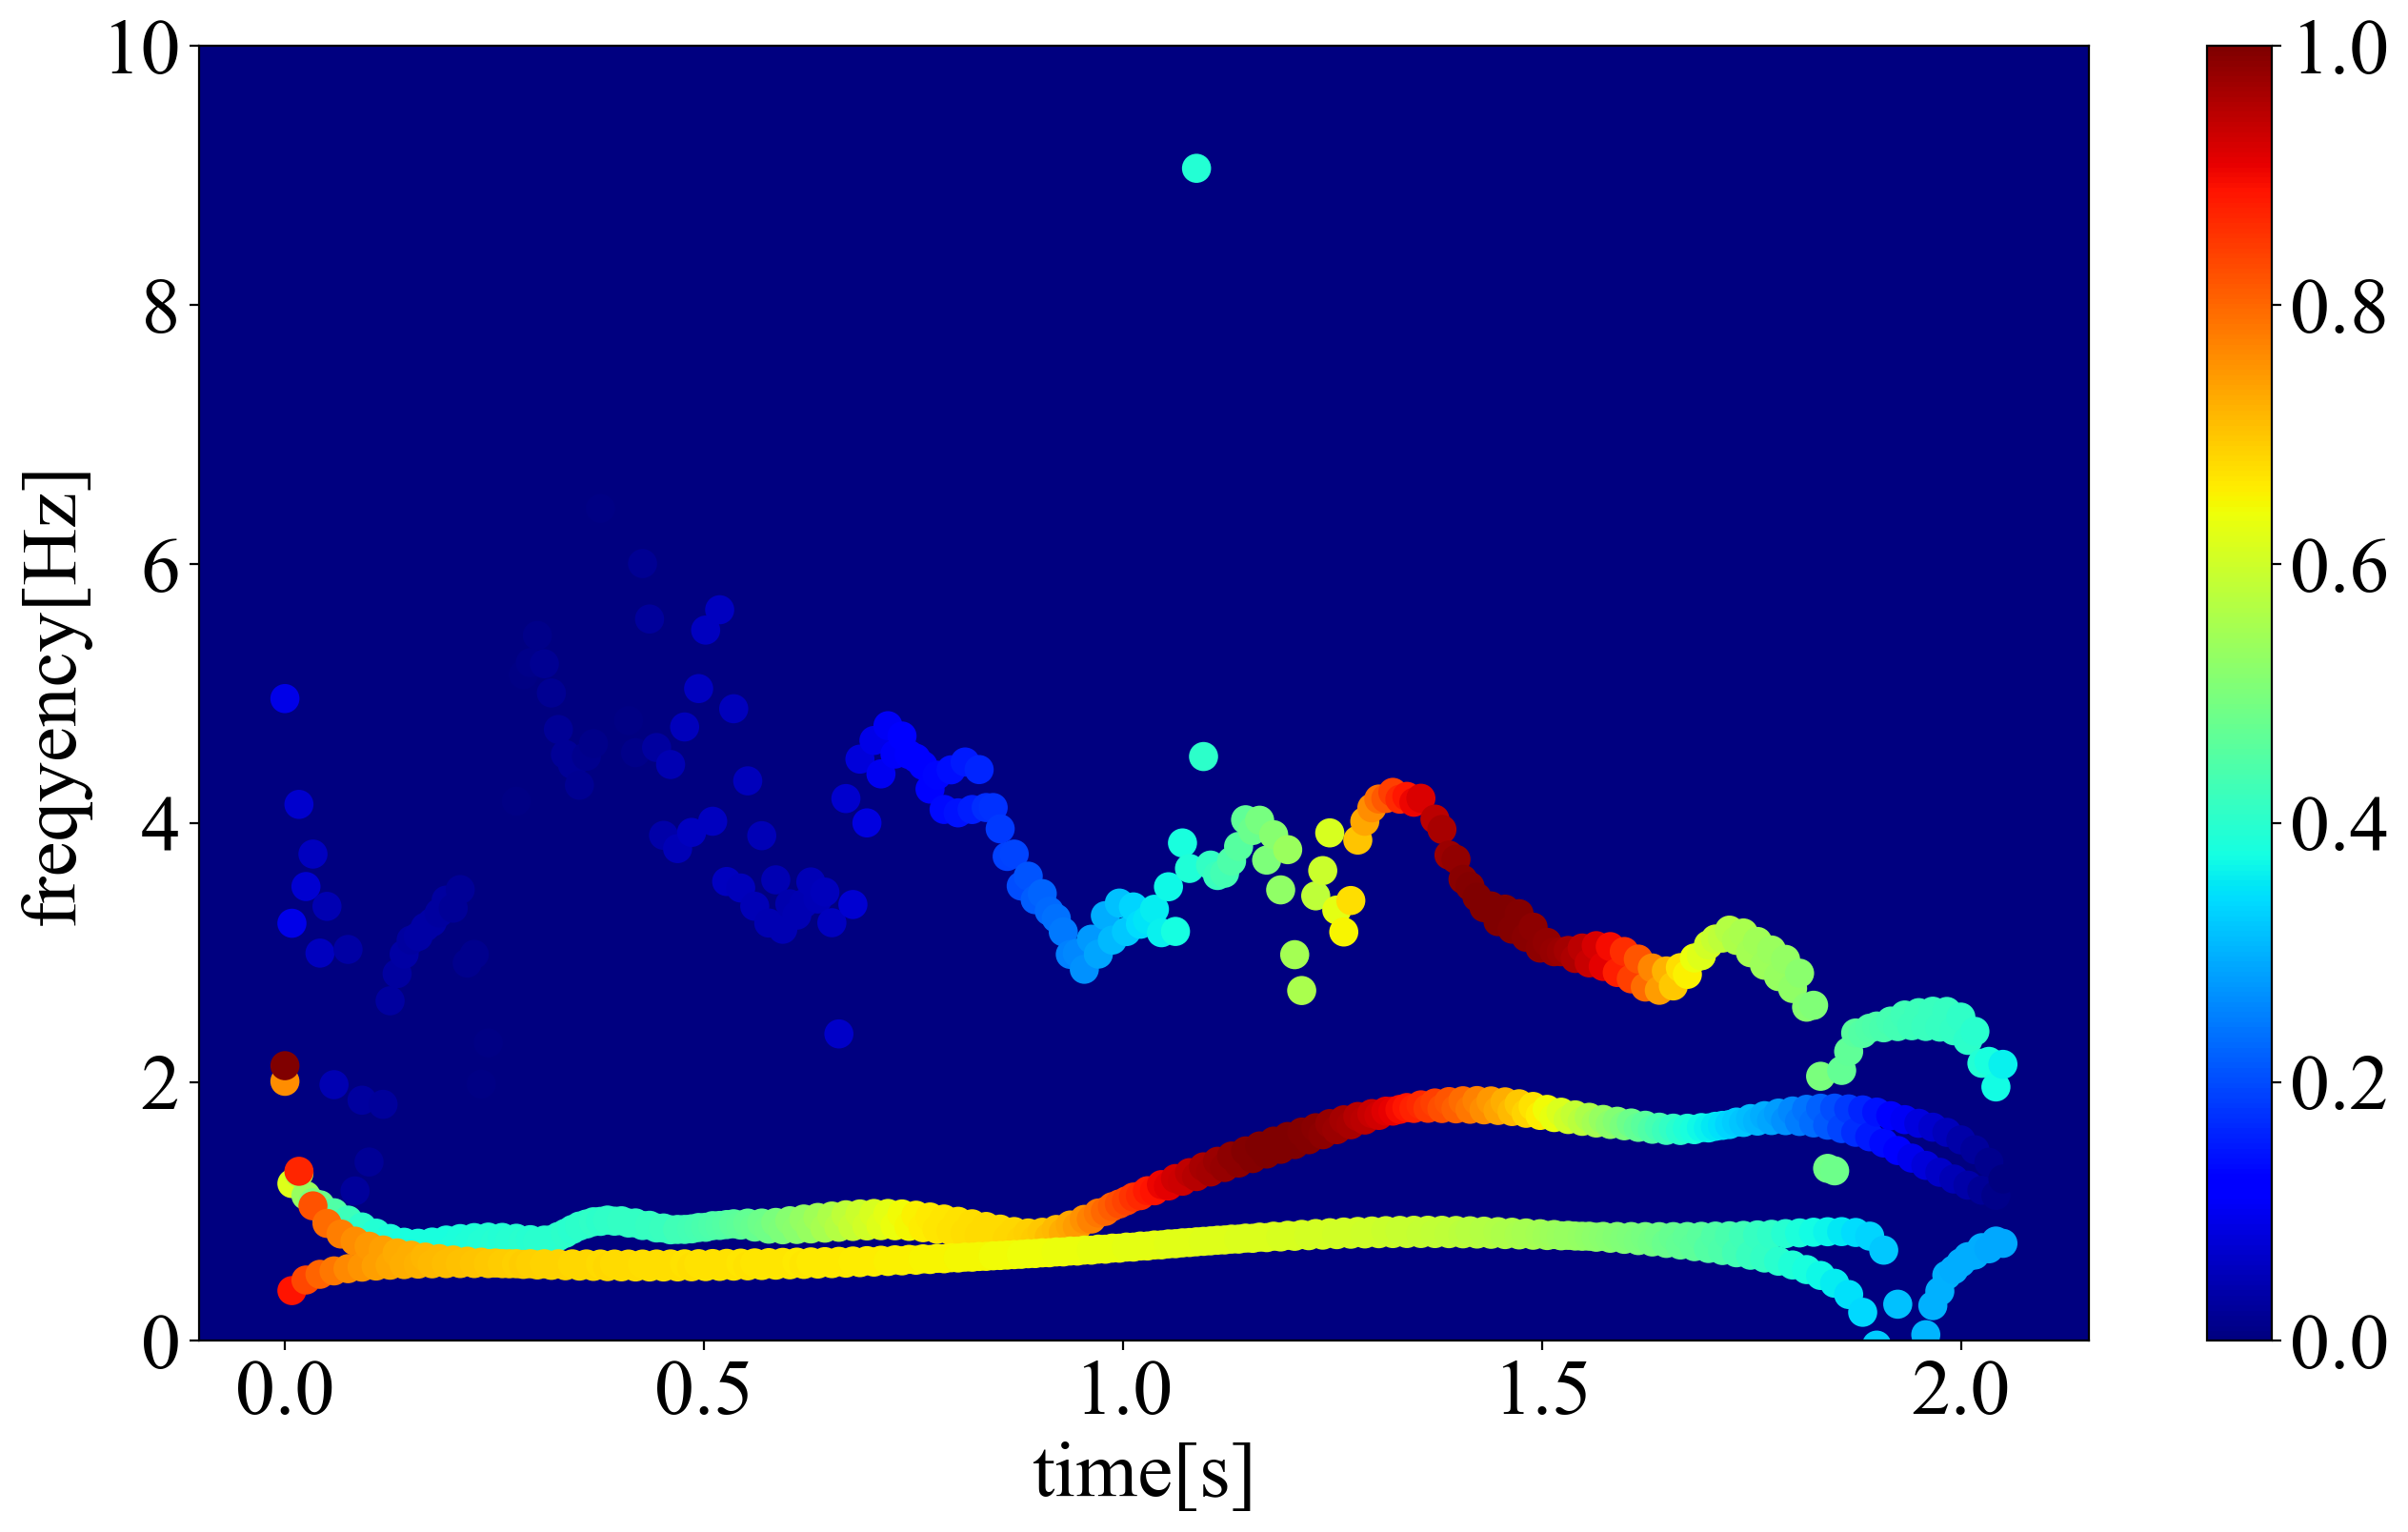

In [32]:
print(select_data)
print(joint_name)
# spectrogram plot
plt.clf()
plt.figure(dpi = 200, figsize=(16, 9))
plt.rcParams['font.family'] = 'Times new Roman'
plt.rcParams['font.size'] = 30
for n in range(3, Nod):
    plt.scatter(spectrum_time[n, :], all_freq_data[n, :], s = 100, c=all_amp_data[n, :frame], cmap='jet')
ax = plt.gca()
ax.set_facecolor([0.0, 0.0, 0.5])
plt.ylim(0, 10)
plt.xlabel('time[s]')
plt.ylabel('freqyency[Hz]')
plt.colorbar()
# plt.clim(0,1)
# check 5 Rename the file after each plot
file_name = joint_name + '_' + select_data + '_' + 'IMF4_IMF5_IMF6.png'
plt.savefig(os.path.join(save_path, file_name))
plt.show()